In [15]:
#1. Kütüphanelerin yüklenmesi :

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import shap
import warnings
warnings.filterwarnings("ignore")


🚩 AŞAMA 1: Problem Tanımı ve Hedef
Amaç:
Müşterinin bir siparişi iade etme riskini tahmin eden bir derin öğrenme sınıflandırma modeli kurmak.

Giriş Verileri:
discount, quantity, unit_price → bunlardan spending = quantity * unit_price * (1 - discount) hesaplanabilir.

Çıkış (hedef değişken):
İade Edildi mi? → 0 veya 1

Etiketleme mantığı:

- Yüksek indirim (% > 0.2) &
- Düşük harcama (örneğin alt %25'lik dilim) 

→ iade edilmiş (1)
→ iade edilmemiş (0)

In [28]:
#2. Veri setinin yüklenmesi ve etiketlenmesi :

df = pd.read_csv("Northwind.csv")

# Spending (harcama) hesapla
df["spending"] = df["unit_price"] * df["quantity"] * (1 - df["discount"])

# Etiketleme: sahte hedef değişken oluştur
q25 = df["spending"].quantile(0.25)
df["return_risk"] = np.where((df["discount"] > 0.001) & (df["spending"] < q25), 1, 0)

print(df["return_risk"].value_counts(normalize=True))

return_risk
0    0.910441
1    0.089559
Name: proportion, dtype: float64


In [29]:
df

,order_id,customer_id,order_date,ship_country,unit_price,quantity,discount,category_id,product_id,order_size,season,spending,return_risk
0,10248,VINET,1996-07-04,France,14.00,12,0.00,4,11,168.000,Summer,168.000,0
1,10248,VINET,1996-07-04,France,9.80,10,0.00,5,42,98.000,Summer,98.000,0
2,10248,VINET,1996-07-04,France,34.80,5,0.00,4,72,174.000,Summer,174.000,0
3,10249,TOMSP,1996-07-05,Germany,18.60,9,0.00,7,14,167.400,Summer,167.400,0
4,10249,TOMSP,1996-07-05,Germany,42.40,40,0.00,7,51,1696.000,Summer,1696.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2150,11077,RATTC,1998-05-06,USA,33.25,2,0.03,5,64,64.505,Spring,64.505,1
2151,11077,RATTC,1998-05-06,USA,17.00,1,0.00,2,66,17.000,Spring,17.000,0
2152,11077,RATTC,1998-05-06,USA,15.00,2,0.01,8,73,29.700,Spring,29.700,1
2153,11077,RATTC,1998-05-06,USA,7.75,4,0.00,1,75,31.000,Spring,31.000,0


In [31]:
#3 Özellik Seçimi ve Normalizasyon :

features = ["discount", "quantity", "spending"]
X = df[features].values
y = df["return_risk"].values

# Train-test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ölçekleme
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
#4. cost-sensitive ile modelin azınlıkları da öğrenmesi hedeflenmiştir : 

# Class weight hesapla
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(weights, dtype=torch.float32)


In [33]:
# Torch ile risk hesaplaması yapan fonksiyon oluşturuyoruz : 

class ReturnRiskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3, 16)
        self.fc2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))


In [34]:
# 5. Modelin Eğitilmesi: 

# Tensor veri seti
train_ds = TensorDataset(torch.tensor(X_train).float(), torch.tensor(y_train).float().unsqueeze(1))
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# Model, optim, loss
model = ReturnRiskModel()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss(weight=class_weights[1])  # sadece 1 sınıfına ağırlık vermek için

# Eğitim
epochs = 50
for epoch in range(epochs):
    for xb, yb in train_dl:
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

Epoch 0: Loss = 2.5632
Epoch 10: Loss = 0.3114
Epoch 20: Loss = 0.8900
Epoch 30: Loss = 0.3627
Epoch 40: Loss = 0.1541


Açıklama : 

- Epoch 0: Loss = 2.5632 -> Normal 
- Epoch 10: Loss = 0.3114 -> model hızlı öğrenmeye geçmiştir
- Epoch 20: Loss = 0.8900 -> anlamlı bir artış oldu (overfitting riski!)
- Epoch 30: Loss = 0.3627 -> Dalgalanma var ama toparlanma başlamıştır.
- Epoch 40: Loss = 0.1541 -> Değerlendirildiğinde model başarılı olmuştur.

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       392
           1       0.93      0.97      0.95        39

    accuracy                           0.99       431
   macro avg       0.96      0.98      0.97       431
weighted avg       0.99      0.99      0.99       431



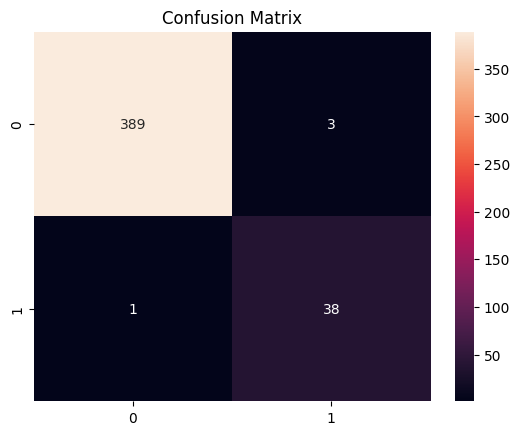

In [35]:
# 6. Modelin Değerlendirilmesi: 

# Test
model.eval()
with torch.no_grad():
    test_preds = model(torch.tensor(X_test).float()).numpy().flatten()
    test_preds_label = (test_preds > 0.5).astype(int)

print(classification_report(y_test, test_preds_label))
sns.heatmap(confusion_matrix(y_test, test_preds_label), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


100%|██████████| 10/10 [00:00<00:00, 1307.37it/s]


<Figure size 640x480 with 0 Axes>

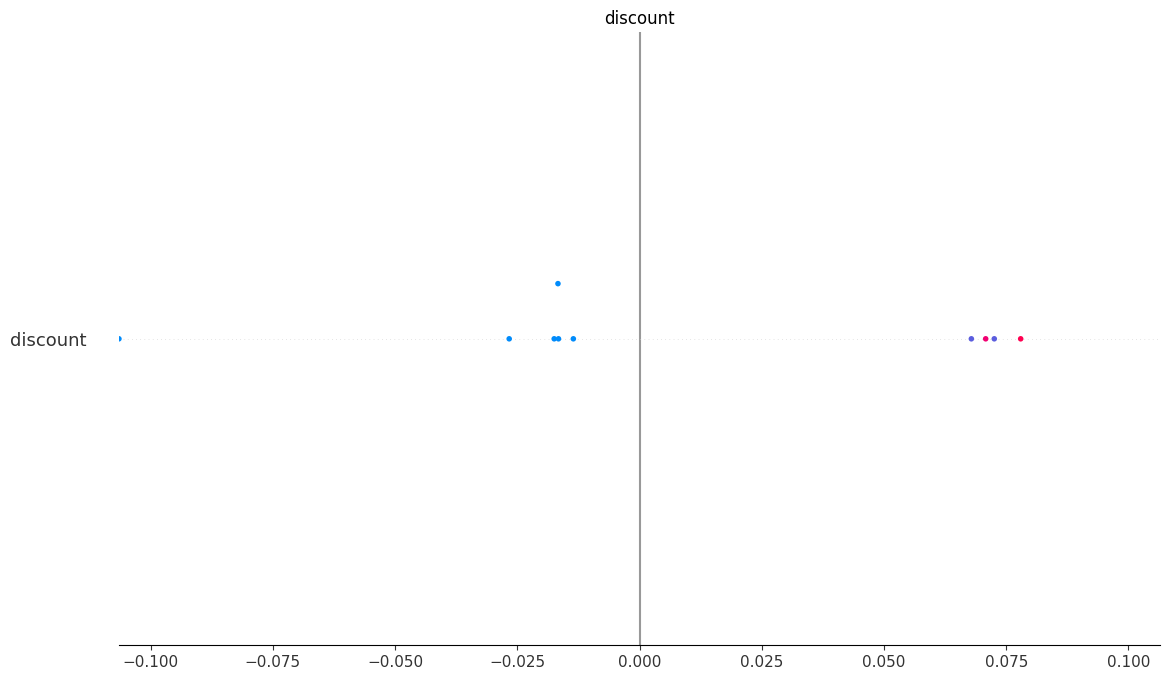

In [37]:
#7. Açıklanabilir AI (SHAP)

# SHAP için modelin predict fonksiyonu
def model_predict(X_array):
    with torch.no_grad():
        preds = model(torch.tensor(X_array).float())
    return preds.numpy()

# SHAP KernelExplainer
explainer = shap.KernelExplainer(model_predict, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])

# Görselleştir
shap.summary_plot(shap_values, X_test[:10], feature_names=features)


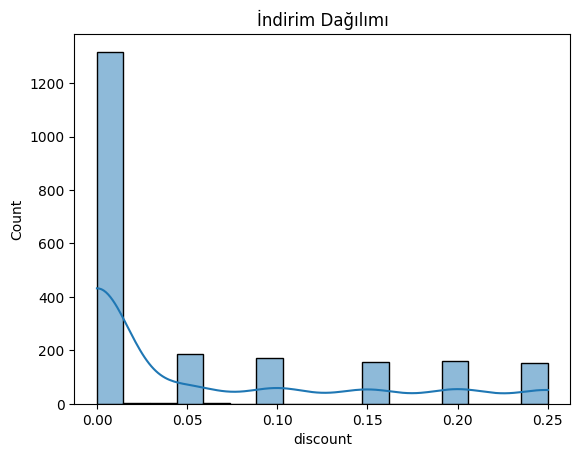

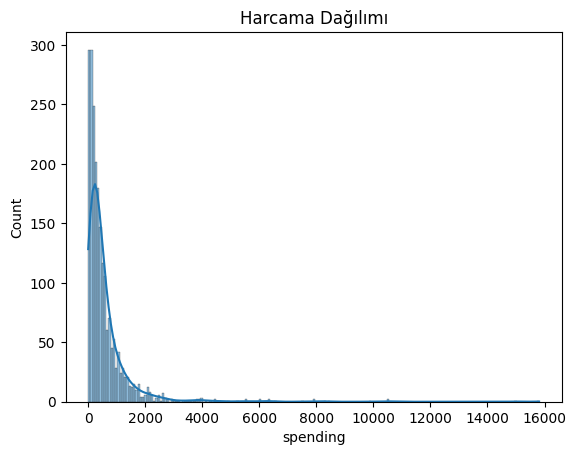

In [11]:
sns.histplot(data['discount'], kde=True)
plt.title("İndirim Dağılımı")
plt.show()

sns.histplot(data['spending'], kde=True)
plt.title("Harcama Dağılımı")
plt.show()


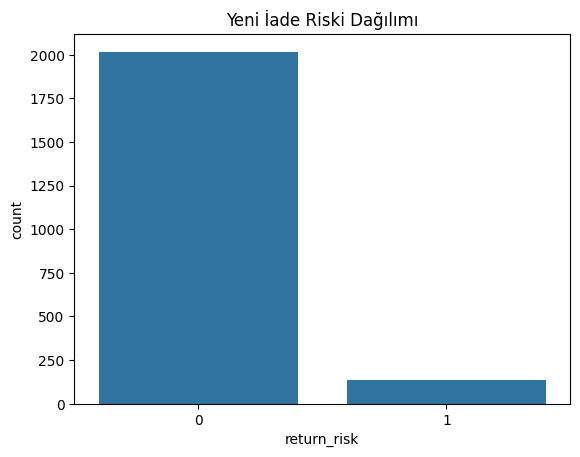

In [20]:
# Daha esnek sahte etiket
#data['return_risk'] = ((data['discount'] > 0.2) & (data['spending'] < 100)).astype(int)
data['return_risk'] = ((data['discount'] > 0.02) & (data['spending'] < 100)).astype(int)


# Sınıf dağılımına tekrar bak
sns.countplot(x='return_risk', data=data)
plt.title("Yeni İade Riski Dağılımı")
plt.show()


In [21]:
discount_thresh = data['discount'].quantile(0.75)  # yüksek indirim
spending_thresh = data['spending'].quantile(0.25)  # düşük harcama

data['return_risk'] = ((data['discount'] > discount_thresh) & 
                       (data['spending'] < spending_thresh)).astype(int)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data[['discount', 'quantity', 'spending']]
y = data['return_risk']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Class weight hesapla
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(weights))

# Model tanımı
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğit
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_split=0.2, class_weight=class_weights, verbose=1)


Epoch 1/30


/Users/elifdy/miniconda3/envs/tfenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2045 - loss: 0.6030 - val_accuracy: 0.6609 - val_loss: 0.6885
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6994 - loss: 0.4874 - val_accuracy: 0.8667 - val_loss: 0.5915
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.8162 - loss: 0.4051 - val_accuracy: 0.8870 - val_loss: 0.4801
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.8553 - loss: 0.3454 - val_accuracy: 0.8928 - val_loss: 0.3824
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.8511 - loss: 0.2919 - val_accuracy: 0.9014 - val_loss: 0.3044
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8674 - loss: 0.2253 - val_accuracy: 0.9072 - val_loss: 0.2566
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8555 - loss: 0.2063 - val_accuracy: 0.9188 - val_loss: 0.2076
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8733 - loss: 0.2028 - val_accuracy: 0.9188 - val_loss: 0.

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       409
           1       0.49      1.00      0.66        22

    accuracy                           0.95       431
   macro avg       0.74      0.97      0.81       431
weighted avg       0.97      0.95      0.96       431



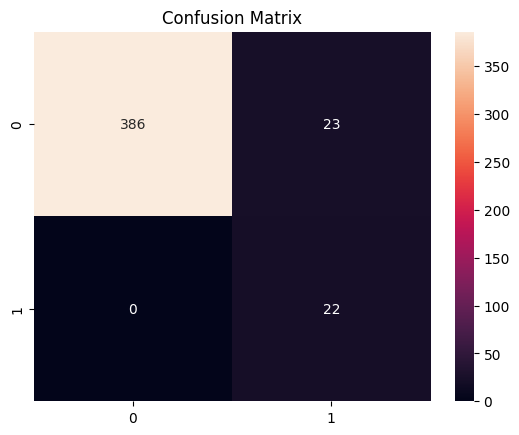

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test) > 0.5

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


 20%|██        | 2/10 [00:00<00:00, 17.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step


 40%|████      | 4/10 [00:00<00:00, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step


 60%|██████    | 6/10 [00:00<00:00, 17.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step


 80%|████████  | 8/10 [00:00<00:00, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step


100%|██████████| 10/10 [00:00<00:00, 17.08it/s]


<Figure size 640x480 with 0 Axes>

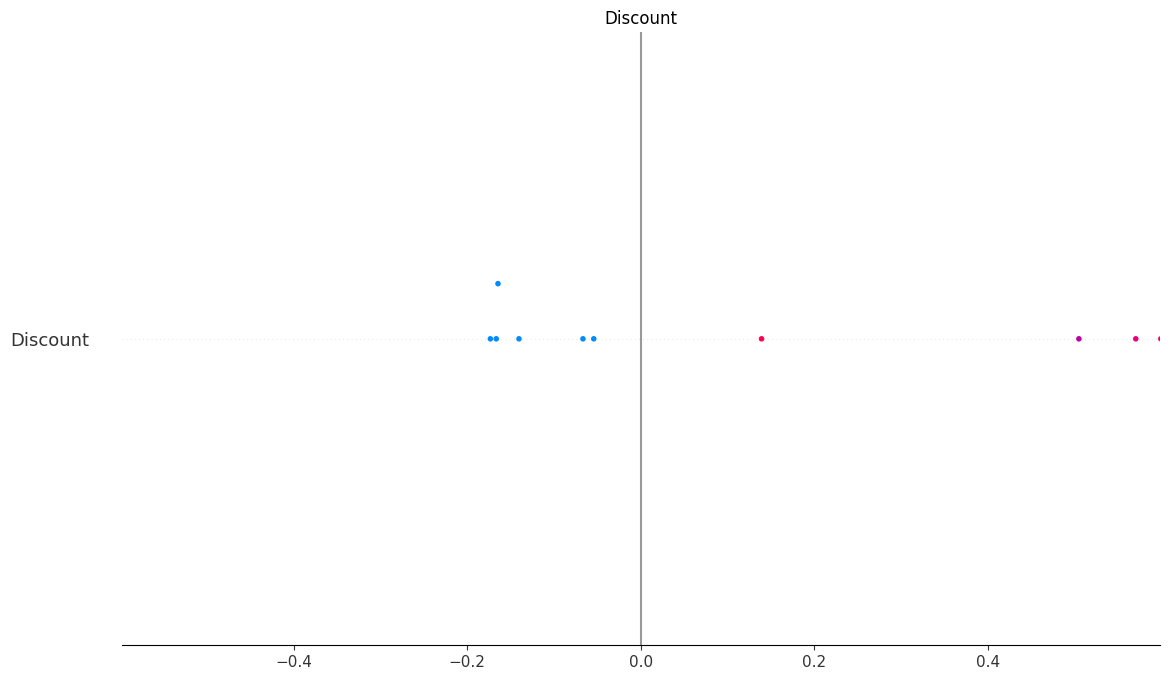

In [25]:
import shap

explainer = shap.KernelExplainer(model.predict, X_train[:100])  # deep explainer için tensorflow graph gerekebilir
shap_values = explainer.shap_values(X_test[:10])

shap.summary_plot(shap_values, X_test[:10], feature_names=['Discount', 'Quantity', 'spending'])
